In [62]:
import cv2
from glob import glob
import pandas as pd
import numpy as np

import torch

import rasterio
from rasterio.mask import mask
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
df_train = gpd.read_file("datasets/Varuna Hackathon 2022/training_area/traindata.shp")
df_test = gpd.read_file("datasets/Varuna Hackathon 2022/testing_area/testdata.shp")

grid_aoi = gpd.read_file("datasets/Varuna Hackathon 2022/Grid_AOI/AOI.shp")

df_train['area'] = df_train['geometry'].apply(lambda x: x.area)
df_test['area'] = df_test['geometry'].apply(lambda x: x.area)

df_train

,years,crop_type,geometry,area
0,2021,1,"POLYGON ((774604.014 1671240.055, 774606.506 1...",7395.766301
1,2021,1,"POLYGON ((773367.837 1670278.438, 773389.600 1...",12760.987757
2,2021,1,"POLYGON ((771648.671 1673990.960, 771707.027 1...",41971.752161
3,2021,3,"POLYGON ((771306.117 1674174.738, 771426.678 1...",8416.322100
4,2021,2,"POLYGON ((763750.339 1678588.825, 763879.691 1...",13915.426881
...,...,...,...,...
1312,2021,3,"POLYGON ((769004.617 1679027.544, 769130.199 1...",19370.802033
1313,2021,3,"POLYGON ((772624.509 1673384.254, 772770.291 1...",5249.190746
1314,2021,1,"POLYGON ((774333.243 1669788.192, 774337.269 1...",17355.845596
1315,2021,3,"POLYGON ((768880.988 1687424.354, 768996.565 1...",19346.460336


In [65]:
df_test

,years,geometry,area
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",15600.801589
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",5241.357895
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",7953.663101
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",5383.128092
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",9501.701954
...,...,...,...
560,2021,"POLYGON ((765232.017 1669738.988, 765300.407 1...",12998.681742
561,2021,"POLYGON ((766193.230 1670482.458, 766188.792 1...",24875.466066
562,2021,"POLYGON ((764212.922 1682017.688, 764070.965 1...",30487.128565
563,2021,"POLYGON ((763019.219 1680315.869, 762993.636 1...",10403.743348


In [64]:
df_test.shape

(565, 3)

In [31]:
df_train['area'].argmax()

1177

In [28]:
df_train['geometry'].apply(lambda x: x.area)

0        7395.766301
1       12760.987757
2       41971.752161
3        8416.322100
4       13915.426881
            ...     
1312    19370.802033
1313     5249.190746
1314    17355.845596
1315    19346.460336
1316    26623.104296
Name: geometry, Length: 1317, dtype: float64

In [5]:
def extract_feature(x):
    file_sep = x.split('.')
    name_feature = file_sep[0].split('_')
    return [name_feature[2],file_sep[-1]]

file_path = glob('datasets/Varuna Hackathon 2022/sentinel-2 image/*/*/*/*')
df_img = pd.DataFrame([[i]+i.split('/')[-4:] for i in file_path],columns=['raw_path','year','yyyymmdd','filetype','filename'])
df_img = df_img[df_img['filetype']=="IMG_DATA"].reset_index(drop=True)

df_file_feat = pd.DataFrame([extract_feature(df_img['filename'][i]) for i in range(df_img.shape[0])],columns=['band','file_format'])
df_img = pd.concat([df_img,df_file_feat],axis=1)
df_img = df_img[df_img.file_format=="jp2"].reset_index(drop=True)
df_img

,raw_path,year,yyyymmdd,filetype,filename,band,file_format
0,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2020,20200102,IMG_DATA,47PQS_20200102_AOT.jp2,AOT,jp2
1,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2020,20200102,IMG_DATA,47PQS_20200102_B01.jp2,B01,jp2
2,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2020,20200102,IMG_DATA,47PQS_20200102_B02.jp2,B02,jp2
3,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2020,20200102,IMG_DATA,47PQS_20200102_B03.jp2,B03,jp2
4,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2020,20200102,IMG_DATA,47PQS_20200102_B04.jp2,B04,jp2
...,...,...,...,...,...,...,...
2125,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2021,20211227,IMG_DATA,47PQS_20211227_B12.jp2,B12,jp2
2126,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2021,20211227,IMG_DATA,47PQS_20211227_B8A.jp2,B8A,jp2
2127,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2021,20211227,IMG_DATA,47PQS_20211227_SCL.jp2,SCL,jp2
2128,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2021,20211227,IMG_DATA,47PQS_20211227_TCI.jp2,TCI,jp2


In [8]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self,df_img, normalize = True, img_size = 2051):
        self.df_img = df_img
        self.unique_date = df_img.yyyymmdd.unique()
        self.normalize = normalize
        self.img_size = img_size

    def __len__(self):
        return len(self.unique_date)
    def __getitem__(self, idx):
        data = self.df_img[self.df_img.yyyymmdd==self.unique_date[idx]]
        data.index = data.band.values
        data = data.to_dict()
        raw_path = data['raw_path']

        rgb = np.concatenate([self.read_jp2(raw_path['B02'])[:,:,None],self.read_jp2(raw_path['B03'])[:,:,None],self.read_jp2(raw_path['B04'])[:,:,None]],axis=-1)
        # rgb = (rgb/3558 *255).astype('uint8')
        return {'image': rgb}

    def read_jp2(self,x):
        elhas_raster = rasterio.open(x)
        inputArray = elhas_raster.read()[0]

        inputArray = cv2.resize(inputArray, (self.img_size,self.img_size), interpolation = cv2.INTER_AREA)
        if self.normalize:
            # vmin, vmax = np.nanpercentile(inputArray, (5,95))
            vmin,vmax = 0,3558 
            inputArray = np.clip((inputArray-vmin)/(vmax-vmin),0,1)
        
        return inputArray
dataset = ImageDataset(df_img)

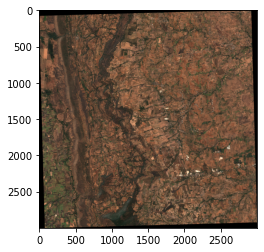

In [86]:
rgb = dataset[1]['image']

plt.imshow(rgb[:,:,::-1])

In [87]:
rgb.shape

(3000, 3000, 3)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': 0.0, 'width': 2051, 'height': 2051, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(10.0, 0.0, 754360.0,
       0.0, -10.0, 1688690.0)}


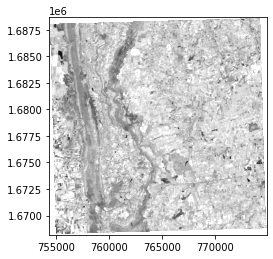

<AxesSubplot:>

In [58]:
from rasterio.plot import show

idx = 1
data = dataset.df_img[dataset.df_img.yyyymmdd==dataset.unique_date[idx]]
data.index = data.band.values
data = data.to_dict()
raw_path = data['raw_path']

elhas_raster = rasterio.open(raw_path['B08'])
print(elhas_raster.meta)

elhas_arr = elhas_raster.read()
vmin, vmax = np.nanpercentile(elhas_arr, (5,95))
show(elhas_raster, cmap='gray', vmin=vmin, vmax=vmax)

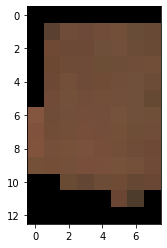

In [61]:
def read_jp2_with_mask(jp2_file,shapes):
    with rasterio.open(jp2_file) as src:
        out_image, out_transform = mask(src, shapes, crop=True)
        # out_meta = src.meta
    inputArray = out_image[0]
    if True:
            # vmin, vmax = np.nanpercentile(inputArray, (5,95))
            vmin,vmax = 0,3558 
            inputArray = np.clip((inputArray-vmin)/(vmax-vmin),0,1)
    return inputArray

# shapes = [df_train.geometry[1177]]
shapes = [df_train.geometry[0]]
rgb = np.concatenate([read_jp2_with_mask(raw_path['B02'],shapes)[:,:,None],read_jp2_with_mask(raw_path['B03'],shapes)[:,:,None],read_jp2_with_mask(raw_path['B04'],shapes)[:,:,None]],axis=-1)
plt.imshow(rgb[:,:,::-1])

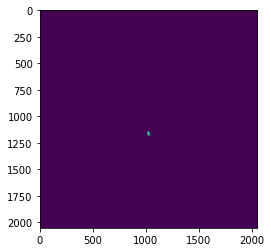

<AxesSubplot:>

In [84]:
shapes = [df_train.geometry[1177]] # [0]
with rasterio.open(raw_path['B04']) as src:
    out_image, out_transform = mask(src, shapes, crop=False)
    out_meta = src.meta
show(out_image)

In [91]:
def read_jp2_no_crop(x):
    elhas_raster = rasterio.open(x)
    inputArray = elhas_raster.read()[0]
    return inputArray
[read_jp2_no_crop(i).shape for i in raw_path.values()]

[(2051, 2051),
 (341, 341),
 (2051, 2051),
 (2051, 2051),
 (2051, 2051),
 (1025, 1025),
 (1025, 1025),
 (1025, 1025),
 (2051, 2051),
 (1025, 1025),
 (1025, 1025),
 (1025, 1025),
 (1025, 1025),
 (2051, 2051),
 (2051, 2051)]

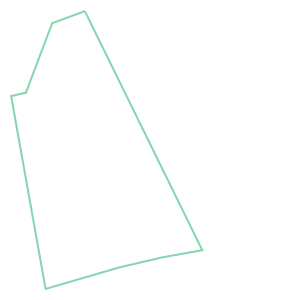

In [83]:
shapes[0].boundary

In [82]:
dir(shapes[0])

['__and__',
 '__array_interface__',
 '__bool__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__geom__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__p__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '__xor__',
 '_array_interface_base',
 '_crs',
 '_ctypes',
 '_ctypes_data',
 '_empty',
 '_exterior',
 '_geom',
 '_get_coords',
 '_interiors',
 '_is_empty',
 '_lgeos',
 '_ndim',
 '_other_owned',
 '_repr_svg_',
 '_set_coords',
 '_set_geom',
 'almost_equals',
 'area',
 'array_interface_base',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'convex_hull',
 'coords',
 'covered_by',
 'covers',
 'crosses',
 'ctypes',
 'difference',
 'disjoint',
 'distance',

In [39]:
out_image

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)

In [27]:
dir(out_transform)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_field_defaults',
 '_fields',
 '_fields_defaults',
 '_make',
 '_replace',
 '_scaling',
 'a',
 'almost_equals',
 'b',
 'c',
 'column_vectors',
 'count',
 'd',
 'determinant',
 'e',
 'eccentricity',
 'f',
 'from_gdal',
 'g',
 'h',
 'i',
 'identity',
 'index',
 'is_conformal',
 'is_degenerate',
 'is_identity',
 'is_orthonormal',
 'is_proper',
 'is_rectilinear',
 'itransform',
 'permutation',
 'precision',
 'rotation',
 'rotation_angle',
 'scale',
 'shear',
 'to_

In [25]:
df_train.geometry[1].area

12760.987756806753